In [26]:
import numpy as np
from os import listdir
from PIL import Image
import PIL
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.decomposition import PCA

from skimage.transform import resize, rescale
from skimage import filters
from skimage import morphology
from skimage.color import rgb2gray

In [2]:
def prep_im(im_id, im_dir_path = "", scalar = 1, output_shape = None):
    '''Prepare image from im_id and optional dictory path.
    If directory path is not passed, the whole filepath, including filetype notation, 
    should be given as im_id. If parameter scalar is passed, output image will be scaled by it. 
    Defualt 1 retains original size.
    
    Args:
        im_id (str): image ID
        im_dir_path (str, optional): image directory path
        scalar (float, optional): rescale coefficient

    Returns:
        im (numpy.ndarray): image.
    '''

    # Read and resize image
    if im_dir_path == "":
        im = plt.imread(im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    else:
        im = plt.imread(im_dir_path + im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    im = rescale(im, scalar, anti_aliasing=True, channel_axis = 2) #IDWE: Use channel_axis=2 to prevent picture from being turned bianry when rescaled
    if output_shape != None:
        im = resize(im, output_shape)

    return im

In [13]:
# Load images
image_folder_path = "imgs_part_1"
paths = [f for f in listdir(image_folder_path) if isfile(join(image_folder_path, f))]

images = []
for im_path in paths:
    image = prep_im(im_path, "imgs_part_1/", output_shape = (300,300))
    arr = np.asarray(image)
    images.append(arr)

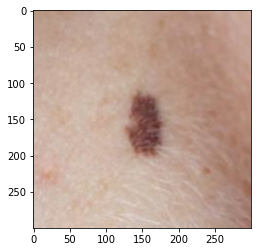

In [4]:
plt.imshow(images[1])

In [20]:
def generate_rgb_mask(im):
    val0 = filters.threshold_otsu(im[:,:,0]*256)
    val1 = filters.threshold_otsu(im[:,:,1]*256)
    val2 = filters.threshold_otsu(im[:,:,2]*256)

    im_mask = (im[:,:,1]*256<val1) & (im[:,:,2]*256<val2)
    
    struct_el = morphology.disk(3)
    im_mask = morphology.binary_opening(im_mask, struct_el)
    
    return im_mask

In [6]:
def generate_mask(im):
    im = rgb2gray(im)*256
    plt.imshow(im, cmap='gray')

    val = filters.threshold_otsu(im)
    im_mask = im < val
    
    struct_el = morphology.disk(3)
    
    im_mask = morphology.binary_opening(im_mask, struct_el)
    
    return im_mask

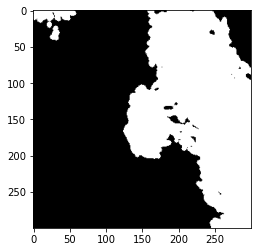

In [7]:
im_mask = generate_mask(images[1])

plt.imshow(im_mask, cmap='gray')

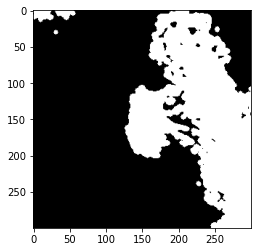

In [10]:
im_mask = generate_rgb_mask(images[1])

plt.imshow(im_mask, cmap='gray')

In [29]:
def save_mask(im, im_path, im_mask):
    mask_path = 'img_segmentation_test/' + '_mask.'.join(im_path.split('.'))
    im_path = 'img_segmentation_test/' + im_path
    
    mpimg.imsave(mask_path,im_mask)
    mpimg.imsave(im_path,im)

In [23]:
for i in range(len(images)):
    im_mask = generate_rgb_mask(images[i])
    
    save_mask(images[i], paths[i], im_mask)

In [89]:
len(images)

10

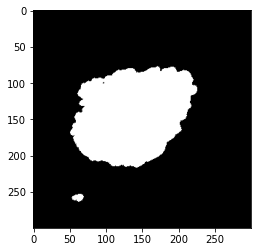

In [21]:
path = 'PAT_72_110_647.png'
im = prep_im(path, "imgs_part_1/", output_shape = (300,300))

val0 = filters.threshold_otsu(im[:,:,0]*256)
val1 = filters.threshold_otsu(im[:,:,1]*256)
val2 = filters.threshold_otsu(im[:,:,2]*256)

im_mask =  (im[:,:,1]*256<val1) & (im[:,:,2]*256<val2)
    
struct_el = morphology.disk(3)
im_mask = morphology.binary_opening(im_mask, struct_el)

plt.imshow(im_mask, cmap='gray')

### PCA

In [24]:
# Flatten it, now each row represents a single image
X = np.stack(images, axis = 0)

dim1, dim2, chan = arr.shape
n_features = chan*dim1*dim2
X = X.reshape((len(images), n_features)) # flattened --> this goes to PCA

print(np.shape(X))

(911, 270000)


In [46]:
# Init the model (a.k.a. specify the hyper-parameters e.g. number of components)
final_n_features = 150 # Hyper-parameter - try different values
pca = PCA(n_components=final_n_features)

In [47]:
# Transformed features
X_transformed = pca.fit_transform(X) # X_new has final_n_features --> this can be fed to the classfier model
X_recovered = pca.inverse_transform(X_transformed)

In [34]:
for i in range(50):
    im_mask = generate_rgb_mask(X_recovered[i].reshape(300,300,3))
    
    save_mask(images[i], paths[i], im_mask)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

### Type specific pca

In [136]:
#Load labels for images
data = np.array([i.strip().split(',') for i in open('metadata.csv')])

mask = data == ''
data[np.where(mask)] = np.nan

labels = data[:,[17,-2]]

In [138]:
len(labels)

2299

In [141]:
mask_ack = labels[:,0] == 'ACK'
mask_bcc = labels[:,0] == 'BCC'
mask_mel = labels[:,0] == 'MEL'
mask_nev = labels[:,0] == 'NEV'
mask_scc = labels[:,0] == 'SCC'
mask_sek = labels[:,0] == 'SEK'

paths_ack = labels[mask_ack,1]
paths_bcc = labels[mask_bcc,1]
paths_mel = labels[mask_mel,1]
paths_nev = labels[mask_nev,1]
paths_scc = labels[mask_scc,1]
paths_sek = labels[mask_sek,1]

paths = [paths_ack, paths_bcc, paths_mel, paths_nev, paths_scc, paths_sek]

In [143]:
# Load images
def load_images(images, paths):
    image_folder_path = "imgs_part_1"

    for im_path in paths:
        image = prep_im(im_path, "imgs_part_1/", output_shape = (300,300))
        arr = np.asarray(image)
        images.append(arr)
    
    return images

In [149]:
def save_images(images, im_paths, folder_path):
    for i in range(len(images)):
        path = folder_path + im_paths[i]
        mpimg.imsave(path,images[i])

In [164]:
images_sek = []
images_sek = load_images(images_sek, paths_sek)

In [167]:
save_images(images_sek, paths_sek, 'imgs_sek/')

In [165]:
len(images_sek)

235

In [166]:
len(images_ack)+len(images_bcc)+len(images_mel)+len(images_nev)+len(images_scc)+len(images_sek)

2298